In [2]:
import os
import numpy as np
import pylab
import imageio
from matplotlib import pyplot as plt
import cv2
import time
from os.path import isfile, join
from keras.applications import mobilenet
from keras.models import load_model
from scipy.ndimage.measurements import label
from scipy.ndimage.measurements import center_of_mass
from matplotlib import colors
import skimage

In [3]:
print(os.listdir('.'))

['.ipynb_checkpoints', 'alt.csv', 'Bebop2_20180414154341-0700.mp4', 'Bebop2_20180414163256-0700.mp4', 'bebop_mobilenet_v0.h5', 'Consolidated Code.ipynb', 'Frames', 'Semantic_Segmentation.ipynb', 'Video Frame Extraction.ipynb']


In [1]:
import os
from keras.preprocessing.image import ImageDataGenerator

# normalization
# normalize each chip
samplewise_center = True
samplewise_std_normalization = True
# normalize by larger batches
featurewise_center = False
featurewise_std_normalization = False

# adjacent pixel correllation reduction
# never explored
zca_whitening = False
zca_epsilon = 1e-6

# data augmentation 
# training only
transform = 0
zoom_range = 0
color_shift = 0
rotate = 0
flip = False

datagen_test = ImageDataGenerator(
        samplewise_center=samplewise_center,
        featurewise_center=featurewise_center,
        featurewise_std_normalization=featurewise_std_normalization,
        samplewise_std_normalization=samplewise_std_normalization,
        zca_whitening=zca_whitening,
        zca_epsilon=zca_epsilon,
        rotation_range=rotate,
        width_shift_range=transform,
        height_shift_range=transform,
        shear_range=transform,
        zoom_range=zoom_range,
        channel_shift_range=color_shift, 
        fill_mode='constant',
        cval=0,
        horizontal_flip=flip,
        vertical_flip=flip,
        rescale=1./255,
        preprocessing_function=None)


C:\Users\anshu\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


**Module to operate on each individual frame of the video**

In [4]:
#Load Weights
model = load_model('bebop_mobilenet_v0.h5', custom_objects={
                   'relu6': mobilenet.relu6,
                   'DepthwiseConv2D': mobilenet.DepthwiseConv2D})

In [32]:
def ProcessChip (frame):
    
    #result_feature_map = np.zeros((9,16,7))  #CNN feature map to be returned
    
    values = np.zeros((9,16,3))
    chips = np.zeros((144,120,120,3))
    for i in range(0,9):
        for j in range(0,16):
            chips[16*i+j] = frame[120*i:120*(i+1), 120*j:120*(j+1), :]
            #values[i][j]=model.predict(np.expand_dims(frame[120*i:120*(i+1), 120*j:120*(j+1), :], 0))
            #chip = frame[120*i:120*(i+1), 120*j:120*(j+1), :]
    
    generator_test = datagen_test.flow(
        chips, 
        batch_size=144,
        shuffle=False)
    
    #return values
    return model.predict_generator(generator_test,
                                  steps = 1)

In [12]:
#All Decision Algo Definition

#Function to find the closest roof/driveway
def closest(list,img_center):
    closest=list[0]
    for c in list:
        if np.linalg.norm(c-img_center) < np.linalg.norm(closest-img_center):
            closest = c
    return closest

#Sliding window function
def sliding_window_view(arr, shape):
    n = np.array(arr.shape) 
    o = n - shape + 1 # output shape
    strides = arr.strides
    
    new_shape = np.concatenate((o, shape), axis=0)
    new_strides = np.concatenate((strides, strides), axis=0)
    return np.lib.stride_tricks.as_strided(arr ,new_shape, new_strides)

In [13]:
##Decision algo with input of 9x16 array at which image was taken.
def decision_algo(image_frame):
    
    image_frame[image_frame==0]=3
   
   ### READ THE ALTITUDE FROM CSV FILE ###
   #Read alt.csv
    with open('alt.csv', 'r') as csvfile:
        alt_list = [line.rstrip('\n') for line in csvfile]

   #Choose last value in alt_list        
    altitude=int(alt_list[-1]) #in meters

   ### ALGORITHM TO FIND CLOSEST DRIVEWAY ###
   #Center of the 9x16 array
    img_center=np.array([4,7.5])

   #Label all the driveways and roofs
    driveway, num_driveway = label(image_frame==1)
    roof, num_roof = label(image_frame==2)

   #Save number of driveways into array
    d=np.arange(1,num_driveway+1)
    r=np.arange(1,num_roof+1)
    
    if(len(d)<1):
        print("No driveway found, returning to baes")
    else:
       #Find the center of the all the driveways
        driveway_center=center_of_mass(image_frame,driveway,d)
        roof_center=center_of_mass(image_frame,roof,r)

       #Find the closest roof to the center of the image
        closest_roof=closest(roof_center,img_center)

       #Find the closest driveway to the closest roof
        closest_driveway=closest(driveway_center,np.asarray(closest_roof))  


       ### ALGORITHM TO FIND 3x3 DRIVEWAY TO LAND ###
       #If altitude is 5m or less, look for a 3x3 sliding window of 1's, if found, Land.
       #At 5m, a 3x3 will be equivalent to 1.5m x 1.5m.
        print (closest_driveway)
        if(altitude<=5.0):

           #Creates a 7x10 ndarray with all the 3x3 submatrices
            sub_image=sliding_window_view(image_frame,(3,3))

           #Empty list
            driveway_list=[]

           #Loop through the 7x14 ndarray
            for i in range(0,7):
                for j in range(i,14):
                   #Calculate the total of the  submatrices
                    output=sum(sum(sub_image[i,j]))
                   #if the output is 9, that means we have a 3x3 that is all driveway
                    if output==9:
                       #append the i(row) and j(column) to a list declared previously
                       #we add 1 to the i and j to find the center of the 3x3
                        driveway_list.append((i+1,j+1))

            if(len(driveway_list)>0):
               #Call closest function to find driveway closest to house.            
                closest_driveway=closest(driveway_list,np.asarray(closest_roof))
                print(closest_driveway)
                print("Safe to land")
            else:
                print("Need to fly lower")
        
        if(len(driveway_center)>0):
            ### SCALE CLOSEST DRIVEWAY CENTER TO REAL WORLD COORDINATES AND SAVE TO CSV ###
            scaler=20.5/(216.26*altitude**-0.953) #cm/pixel
            move_coordinates=np.asarray(closest_driveway)*np.asarray(scaler)*60 #60 is the center of the 120x120 superpixel

            with open('coordinates.csv', 'a', newline='') as csvfile:
                filewriter = csv.writer(csvfile, delimiter=',')
                filewriter.writerow(move_coordinates)

        print(closest_driveway)
    
    return

In [14]:
def heatmap (feature_map, frame):
    color_mask = np.zeros((1080,1920,3))
    temp_frame = skimage.img_as_float(frame)
    alpha = 0.6
    for i in range (0,9):
        for j in range (0,16):
            if feature_map[i][j] == 2:
                color_mask[120*i:120*(i+1), 120*j:120*(j+1), :] = [0, 0, 1] #Blue
            elif feature_map[i][j] == 1:
                color_mask[120*i:120*(i+1), 120*j:120*(j+1), :] = [0, 1, 0] #Green
            else:
                color_mask[120*i:120*(i+1), 120*j:120*(j+1), :] = [1, 0, 0] #Red
    color_mask_hsv = colors.rgb_to_hsv(color_mask)
    frame_hsv = colors.rgb_to_hsv(temp_frame)
    frame_hsv[..., 0] = color_mask_hsv[..., 0]
    frame_hsv[..., 1] = color_mask_hsv[..., 1] * alpha
    frame_masked = colors.hsv_to_rgb(frame_hsv)
    return frame_masked

In [15]:
def correct_arr (arr) :
    arr = arr + 1
    arr[arr>2] = 0
    return arr

**Module to iterate through each frame in video**

In [46]:
def VideoToFrames (vid):
    
    count = 0 # Can be removed. Just to verify number of frames
    #count_pavement = []
    #t = time.time()
    for image in vid.iter_data(): #Iterate through every frame in Video
        #image: numpy array containing image information

        #Insert Function here to operate on frame. For now I've put my ProcessChip() placeholder.
        #ProcessChip is currently just returning a chip. Modify its return statement once CNN function call is added.
        #arr = correct_arr(np.argmax(ProcessChip(image), axis=1))
        #print (arr)
        #count_pavement.extend([np.bincount(np.argmax(frame_feature_map, axis=1))[1]])
        #The following is to just check if frames are being read correctly. Can be removed.
        
        #print(np.expand_dims(image,0).shape)
        if count % 600 == 0:
            print (count)
            feature_map = ProcessChip(image)
            arr = correct_arr(np.argmax(ProcessChip(image), axis=1))
            arr = np.reshape(arr,(9,16))
            plt.imshow(heatmap(arr, image), interpolation='nearest')
            plt.show()
            
        count += 1
    #elapsed = time.time() - t 
    return 

In [48]:
filename = './Bebop2_20180414163256-0700.mp4' #Add path to video file

In [49]:
vid = imageio.get_reader(filename, 'ffmpeg') #You can use any reader of your choice
#print (vid.iter_data())

0


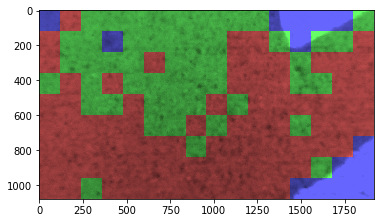

600


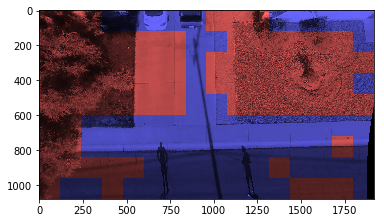

1200


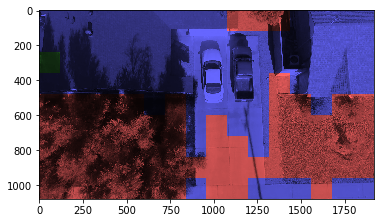

1800


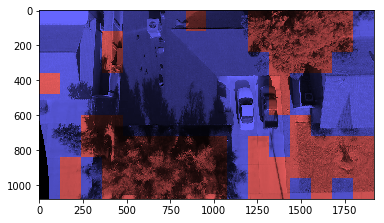

2400


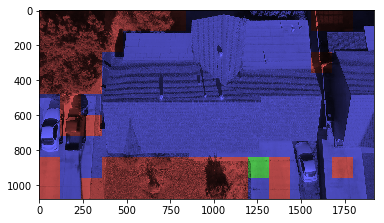

3000


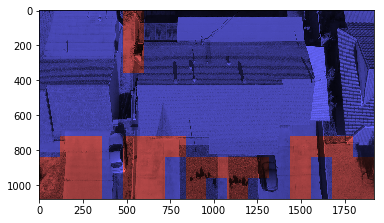

3600


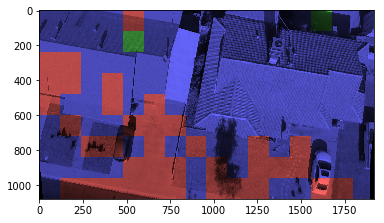

4200


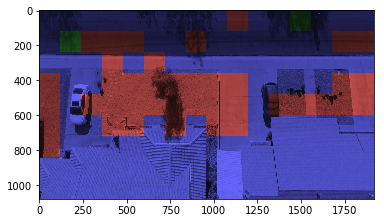

4800


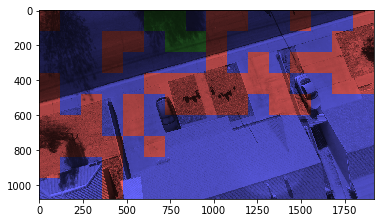

5400


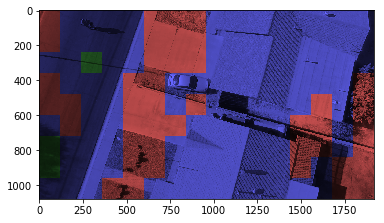

6000


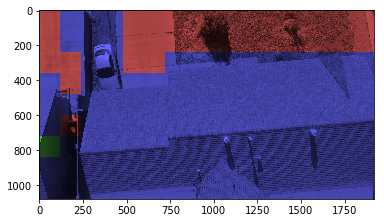

6600


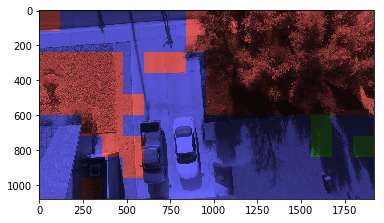

7200


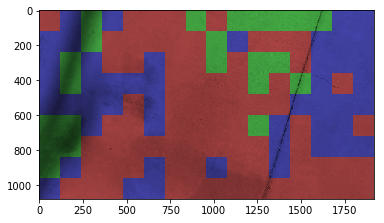

In [50]:
VideoToFrames(vid) #Passing the video to be analyzed frame by frame

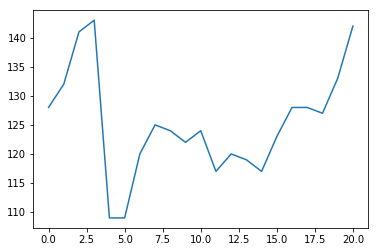

In [79]:
plt.plot(temp)

In [ ]:
[[0 1 0 0 2 2 0 0 2 0 1 2 1 1 1 1]
 [0 0 0 0 2 2 2 2 1 0 1 1 1 1 1 0]
 [0 0 2 2 2 2 0 2 0 1 1 0 0 1 0 0]
 [0 0 2 2 2 2 0 2 0 1 1 1 0 0 0 0]
 [2 2 2 2 1 2 2 2 0 1 1 0 0 0 0 0]
 [0 1 2 2 2 2 2 2 0 0 1 0 1 0 0 0]
 [0 0 0 0 2 0 0 2 0 0 1 0 0 0 0 0]
 [0 0 0 0 1 2 2 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]]